# Maximal predictability to find K, m for Lorenz system
The aim of this script is to find the values of K,m which lead to the best results. In order to do this, the prediction time is maximized.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
import numpy.ma as ma


## Simulating the system
The Lorenz system is simulated. The y coordinate is taken as time series and white noise is added to it.

In [2]:
#parameters of the system
rho = 28
sigma = 10
beta =8/3

#Initial condition
state0 = np.array([-8, -8, 27])

def difeq(data,t):
    '''System of differential eqautions'''
    x,y,z=data
    xp=sigma*(y-x)
    yp=x*(rho-z)-y
    zp=x*y-beta*z
    return [xp,yp,zp]

dt=0.01
T=10000
discard_t = 100
T_total = T+discard_t
t=np.arange(0,T_total,dt)
data=integrate.odeint(difeq,state0,t)[int(discard_t/dt):]
N=len(data)
#Data along X
Xdata=data[:,0]


In [4]:
def getLag(tseries,m):
    '''Input: Lag step tau ( = distance between lags),
    m = dimension of lag vector, tseries = time series data'''
    lengthY=tseries.shape[0]
    Ncolumns=m
    Nrows=lengthY-Ncolumns+1
    x=np.zeros([Nrows,Ncolumns])
    for k in range(Nrows):
        #Constructing the lag vector 
        xk=tseries[k:]
        
        #Broadcasting them into same shape
        xk=np.array(xk[0:Ncolumns])
        x[k,:]=xk
    return x

## Illustrating concept of predictability

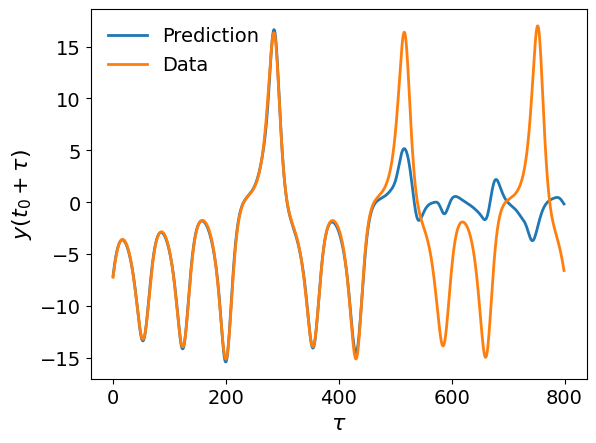

In [6]:
predictedevolution=[]
#Point at which we predict
p0=300

#Dimension of the timeseries
dimtimeseries=1

#Value of K
K=18
m=3


#Number of nearest neighbours included in computations
Np=8

X=getLag(Xdata,K)
#Subtracting the mean of each column
Xmean=X.mean(axis=0)
X_m = X-Xmean
#Covariance matrix of dimension k*k, already normalized
cov = np.cov(X_m.T)
#Diagonalizing the covariance matrix
eigvals,eigvecs = np.linalg.eig(cov)

#Projecting onto principal components
XPCA= X.dot(eigvecs[:,:m])
Steps=len(XPCA)
taumax=800
#Computing distance in reconstructed phase space and keeping Nearest neigbhours
disttoxt=np.sqrt(np.sum(np.square((XPCA[:-taumax]-XPCA[p0])),axis=1))

#Excluding nearest neighbours in time
disttoxt[p0-20:p0+20]=np.Inf

#Keeping only clostest points
sort_index = np.argsort(disttoxt)   

for tau in np.arange(0,taumax):
    #Make sure evolved points are in time series
    indevolved=sort_index+tau
    sel=indevolved<Steps
    indevolved=indevolved[sel]

    #Keeping Np closest neigbours
    indevolved=indevolved[0:Np]

    NearNeighbourst=XPCA[indevolved-tau]
    #Evolved nearest neighbours
    NearNeighbourstnew=XPCA[indevolved]

    #Average over the evolved Nearest neighbours
    xtnew=np.mean(NearNeighbourstnew,axis=0)
    #Go back to real space
    Realspace=xtnew.dot(eigvecs[:,:m].T)
    Realspace=Realspace[0:dimtimeseries]
    predictedevolution.append(Realspace)  

direction=0
fig, ax = plt.subplots()
plt.plot(np.arange(0,tau+1),np.array(predictedevolution)[:,0],linewidth=2,label='Prediction')
plt.plot(np.arange(0,tau+1),data[p0:p0+tau+1,0],linewidth=2,label='Data')
plt.legend(loc='upper left',frameon=False,fontsize=14)
plt.xlabel(r'$\tau$',fontsize=16)
plt.ylabel(r'$y(t_0+\tau)$',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('PredictabilityIllustration.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

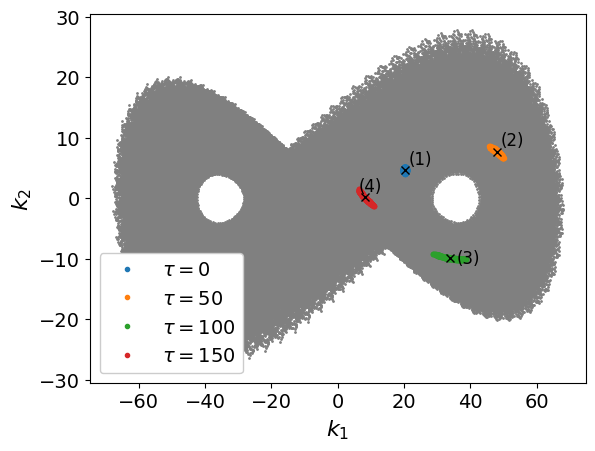

In [7]:
Np=300

#Get Nearest neighbours
NNindex=sort_index[0:Np]
NearNeighbourst=XPCA[NNindex]

tau=50
NearNeighbourst=XPCA[NNindex]
#Evolved nearest neighbours
NearNeighbourstnew1=XPCA[NNindex+tau]
#Average over the evolved Nearest neighbours
point1=np.mean(NearNeighbourstnew1,axis=0)

tau=100
NearNeighbourst=XPCA[NNindex]
#Evolved nearest neighbours
NearNeighbourstnew2=XPCA[NNindex+tau]
#Average over the evolved Nearest neighbours
point2=np.mean(NearNeighbourstnew2,axis=0)

tau=150
NearNeighbourst=XPCA[NNindex]
#Evolved nearest neighbours
NearNeighbourstnew3=XPCA[NNindex+tau]
#Average over the evolved Nearest neighbours
point3=np.mean(NearNeighbourstnew3,axis=0)



fig, ax = plt.subplots()
plt.plot(XPCA[:,0],XPCA[:,1],'.',markersize=2,color='grey',label='_')

plt.plot(NearNeighbourst[:,0],NearNeighbourst[:,1],'.',label=r'$\tau = 0$')
plt.plot(NearNeighbourstnew1[:,0],NearNeighbourstnew1[:,1],'.',label=r'$\tau = 50$')
plt.plot(NearNeighbourstnew2[:,0],NearNeighbourstnew2[:,1],'.',label=r'$\tau = 100$')
plt.plot(NearNeighbourstnew3[:,0],NearNeighbourstnew3[:,1],'.',label=r'$\tau = 150$')


plt.plot(XPCA[p0,0],XPCA[p0,1],'k x',markersize=6,label='_')
plt.text(XPCA[p0,0]+1,XPCA[p0,1]+1,"(1)",fontsize=12)
plt.plot(point1[0],point1[1],'k x',markersize=6,label='_')
plt.text(point1[0]+1,point1[1]+1,"(2)",fontsize=12)
plt.plot(point2[0],point2[1],'k x',markersize=6,label='_')
plt.text(point2[0]+2,point2[1]-1,"(3)",fontsize=12)
plt.plot(point3[0],point3[1],'k x',markersize=6,label='_')
plt.text(point3[0]-1.8,point3[1]+1,"(4)",fontsize=12)


plt.xlabel(r'$k_1$',fontsize=16)
plt.ylabel(r'$k_2$',fontsize=16)
plt.legend(loc='lower left',frameon=True,framealpha=1,fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('PredictionEstimation.png', format='png', dpi=600,bbox_inches='tight')
plt.show()
